# Resnet34 Task A

In [1]:
import os
import numpy as np
import json
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchsummary import summary
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
from collections import defaultdict

from tqdm import tqdm


print(f"Torch version: {torch.__version__}")

Torch version: 2.3.1


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# mac m芯片的gpu，如果不是就删了
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(device)

mps


## Problem Statement and motivation
In this project, our aims are to classify different category for fashion design items. We are separate into two different problems; one is for the main category classification problem with clothing, shoes, accessories, and bags. The other problem contains a more detailed subcategory. The total number of classes is 31. The most challenging part is imbalanced sample class distribution for subcategory classification. We need to solve the strathfield splitting problem first and then modify the current dataset to improve the performance of the model. 

In this project, our motivations are to compare different models for both above mentioned problem and predict fashion design items. It will help clients to add items easily or more efficiently for item classification.  

Here are two approaches to the problem of predicting the main class and its corresponding subclasses:

1. Train separate classifiers for each subclass independently.
2. Use multi-task learning to predict both the main class and subclass outputs during model training.

I will choose multi-task learning method because approach 1 cant use the common features between main classifier and sub classifier. And the data size is too small to train subclass separately. That may cause poor performance on model.

## 1. Generate Dataset

The UT Fashion 100 dataset consists of two parts: AAT and LAT. Base on the requirement, the goal is to classify items into 4 main categories.

However, the labels for the images in AAT and LAT are embedded within a JSON structure, and LAT contains more than the 4 required categories. The first step is to filter and select images corresponding to the 4 main categories along with their labels from both AAT and LAT datasets.

`shoes, clothing, accessories, bags`

In [3]:
# path of images and labels
aat_image_dir = './data/A100/AAT/image/'
aat_label_file = './data/A100/AAT/label/AAT.json'


In [4]:
def parse_main_sub(label_str, flag='AAT'):
    """
    Split the string from json to get the image file's name and with its label
    : params label_str: string item from json
    : params flag: the kind of dataset. AAT and LAT have different method to label in their json file
    """
    if flag == "AAT":
        main_class, temp = label_str.split('/')
        sub_class, image_id = temp.split('_')
    else:
        main_class, image_id = label_str.split('_')
    return main_class, sub_class, image_id

class TaskBFashionDataset(Dataset):
    def __init__(self, aat_image_dir, aat_json_file, transform=None):
        self.transform = transform             
        self.image_paths = []                   # store the path of images
        self.main_labels = []
        self.sub_labels = []
        # Add image paths and labels
        self.add_data(json_file=aat_json_file, image_dir=aat_image_dir, flag='AAT') # generate data by method
        # Record the index of each class
        self.main_class = sorted(list(set(self.main_labels)))
        self.sub_class = self.group_sub_class()


    def group_sub_class(self):
        sub_class_dict = defaultdict(list)
        for main, sub in zip(self.main_labels, self.sub_labels):
            sub_class_dict[main].append(sub)

        grouped_sub_class = []
        for main_class in sorted(sub_class_dict.keys()):
            sub_classes = sorted(list(set(sub_class_dict[main_class])))
            grouped_sub_class.extend(sub_classes)

        return grouped_sub_class


    def add_data(self, json_file, image_dir, flag):
        """
        Append image path and its label to list by the json file.
        """
        with open(json_file, 'r') as f:
            scripts = json.load(f)                      # read the json file's content
            for ls in scripts:
                for phase in ['question', 'answers']:
                    for question in ls[phase]:
                        main_class, sub_class, image_id = parse_main_sub(question, flag)    # split string by function
                        img_path = os.path.join(image_dir, f"{image_id}.jpg")               
                        if os.path.exists(img_path):                                        # check the path
                            self.image_paths.append(img_path)
                            self.main_labels.append(main_class)
                            self.sub_labels.append(sub_class)

    def __len__(self):
        """
        Return the size of dataset
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        The core to make dataset can be iterable
        """
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        main_label = self.main_labels[idx]
        sub_label = self.sub_labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, self.main_class.index(main_label), self.sub_class.index(sub_label)
    

naive_transform = transforms.Compose([
    transforms.ToTensor(),
])
# generate dataset
task_b_dataset = TaskBFashionDataset(aat_image_dir=aat_image_dir,
                                    aat_json_file=aat_label_file,
                                    transform=naive_transform)

In [5]:
main_class_ls = task_b_dataset.main_class
sub_class_ls = task_b_dataset.sub_class

In [6]:
# shape of image
img = task_b_dataset[0][0]
print(f"The shape of image is: {img.shape}")
# length of dataset
print(f"The size of dataset is: {len(task_b_dataset)}")

The shape of image is: torch.Size([3, 1088, 962])
The size of dataset is: 983


In [7]:
def cal_mean_std(dataset):
    means = []
    stds = []
    for i in dataset:
        image = i[0].to(device)             # compute by device
        means.append(image.mean([1,2]).cpu().numpy())
        stds.append(image.std([1,2]).cpu().numpy())
    return np.mean(means, axis=0), np.mean(stds, axis=0)

In [8]:
mean_array, std_array = cal_mean_std(task_b_dataset)
print(mean_array, std_array)

[0.8594339  0.8381103  0.82773745] [0.20753573 0.23300952 0.24602906]


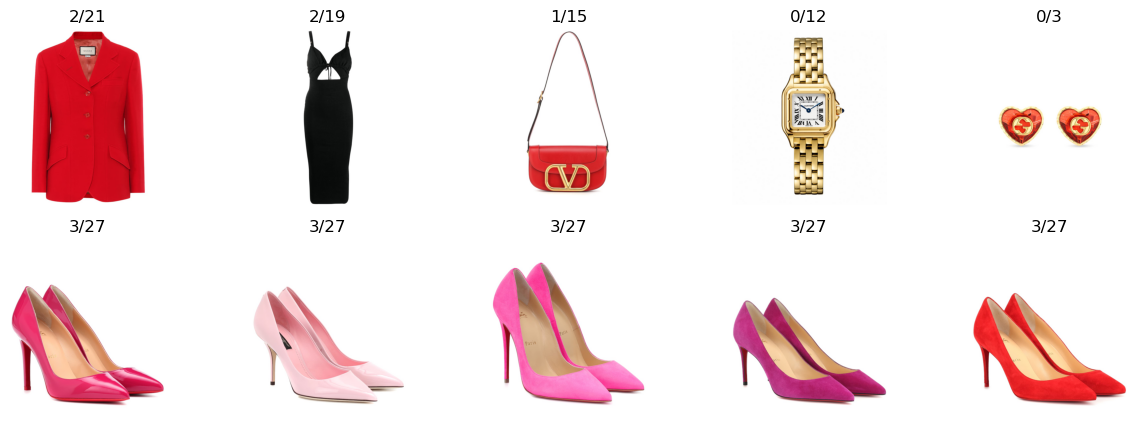

In [9]:
def show_images(dataset):
    to_pil = transforms.ToPILImage()
    num_images = 10
    cols = 5
    rows = 2
    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        img = to_pil(dataset[i][0])
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(f'{dataset[i][1]}/{dataset[i][2]}')
        plt.axis('off')

    plt.show()

show_images(task_b_dataset)

## 2. Split dataset

The filtered dataset has only 983 images. So I need to divide the whole dataset into train, valid without test set. However, after splitting, the data size is too small. So I need to use data augment method to artificially increase the size of the training set.

This category is used to receive the divided data set and form a dataloader that can load data.

In [10]:
class TaskBSplitDataset(Dataset):
    """
    To receive splited dataset and apply transform
    """
    def __init__(self, image_paths, labels, sub_labels, transform=None):
        self.image_paths = image_paths
        self.main_labels = labels
        self.sub_labels = sub_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        main_label = self.main_labels[idx]
        sub_label = self.sub_labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, main_label, sub_label


In [11]:
# split main and sub class from dataset
image_paths = task_b_dataset.image_paths
main_labels = [i[1] for i in task_b_dataset]
sub_labels = [i[2] for i in task_b_dataset]

In [12]:
# record dict for {main : sub}
sub_class_dict = {}
for main, sub in zip(main_labels, sub_labels):
    if main not in sub_class_dict:
        sub_class_dict[main] = set()
    sub_class_dict[main].add(sub)
for k,v in sub_class_dict.items():
    sub_class_dict[k] = list(v)

sub_class_dict

{2: [19, 20, 21, 22, 23, 24],
 1: [13, 14, 15, 16, 17, 18],
 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 3: [25, 26, 27, 28, 29, 30]}

## 3. Transforms

In [13]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),                                     
    transforms.RandomPerspective(distortion_scale=0.3, p=0.3),             
    transforms.RandomRotation(15),  
    transforms.Resize((224,224)),                                          # resnet34 input size 
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])     
    transforms.Normalize(list(mean_array), list(std_array))                # use dataset's std and mean to normalise
])

# dont need to augment for val set
val_test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    transforms.Normalize(list(mean_array), list(std_array))

])


# Use a stratified method to split the dataset, ensuring that each label is evenly distributed 
# between the training and validation sets, thus avoiding the possibility of 
# having labels absent in the validation set. 
# Split the dataset into 80% for training and 20% for validation.
stratified_split_1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(stratified_split_1.split(image_paths, sub_labels))


# apply transforms to each part
train_dataset = TaskBSplitDataset([image_paths[i] for i in train_idx],
                            [main_labels[i] for i in train_idx],
                            [sub_labels[i] for i in train_idx],
                            transform=train_transforms)


val_dataset = TaskBSplitDataset([image_paths[i] for i in val_idx],
                            [main_labels[i] for i in val_idx],
                            [sub_labels[i] for i in val_idx],
                            transform=val_test_transforms)



# generate dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

dataloaders = {'train':train_loader, 'val':val_loader}

# Show the size of dataloader
train_batch = next(iter(dataloaders['train']))
print(f'train batch size: {np.array(train_batch[0]).shape}')
val_batch = next(iter(dataloaders['val']))
print(f'val batch size: {np.array(val_batch[0]).shape}')


train batch size: (32, 3, 224, 224)
val batch size: (32, 3, 224, 224)


In [14]:
from collections import Counter
# Show the split result
train_sub = [sub_labels[i] for i in train_idx]
val_sub = [sub_labels[i] for i in val_idx]
# check all labels are in train and valid set.
print(len(Counter(train_sub)))
print(len(Counter(val_sub)))
print(Counter(train_sub))
print(Counter(val_sub))

31
31
Counter({3: 67, 23: 58, 24: 48, 21: 46, 19: 42, 25: 34, 27: 33, 15: 31, 22: 27, 17: 25, 11: 24, 16: 23, 14: 23, 29: 23, 18: 22, 1: 22, 12: 22, 30: 22, 9: 21, 7: 20, 4: 19, 28: 19, 20: 17, 26: 16, 6: 15, 8: 14, 0: 14, 13: 11, 10: 10, 2: 9, 5: 9})
Counter({3: 17, 23: 15, 21: 12, 24: 12, 19: 10, 25: 8, 15: 8, 27: 8, 22: 7, 12: 6, 16: 6, 17: 6, 29: 6, 11: 6, 14: 6, 4: 5, 7: 5, 9: 5, 28: 5, 1: 5, 30: 5, 18: 5, 20: 4, 6: 4, 8: 4, 26: 4, 13: 3, 0: 3, 10: 3, 2: 2, 5: 2})


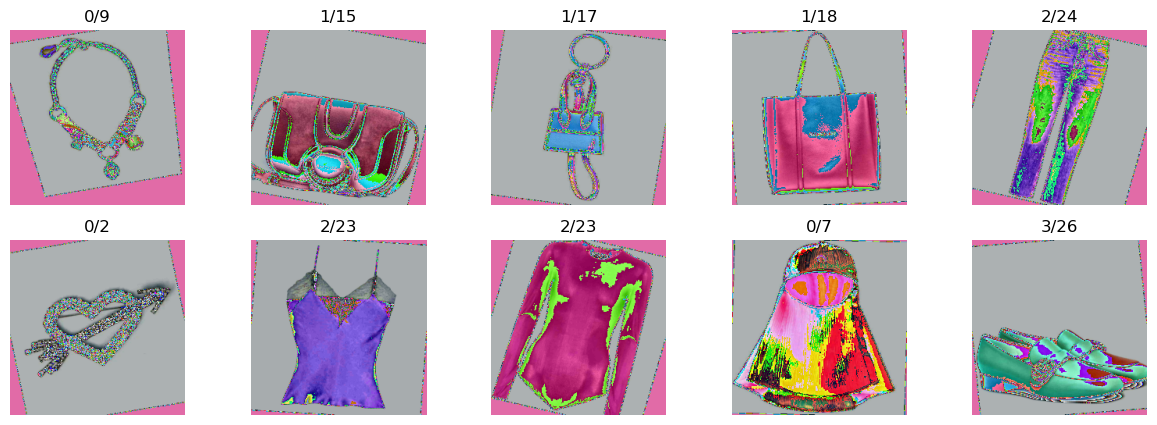

In [15]:
show_images(train_dataset)

## 4. Modifying the Resnet34 Model

I will use ResNet34 from torch as base model. ResNet34 is light and powerful to learn complexity features. It has more layers than some architectures like alexnet, inception net and vgg. Theoretically, such a complex model may have better learning performance than a simple network.

Base on the summary, one resnet block is made by "conv2d -> BatchNorm2d -> ReLU -> conv2d -> BatchNorm2d -> ReLu". And the last linear layer has 1000 output, that means it can classify 1000 classes. However, we only need to classify 4 main classes.
- To maintain the structural integrity and keep the efficiency and practicality. I wont modify the entire architecture of resent34 but **only modify the output layer to adapt our dataset**.
- Use the common features generate by ResNet34 as input for two classifier to process taskA and taskB together.

In [16]:
class MultiLevelClassifier(nn.Module):
    def __init__(self, num_main_classes, num_sub_classes, drop_out_rate=0.3):
        super(MultiLevelClassifier, self).__init__()
        self.num_main_classes = num_main_classes
        self.num_sub_classes = num_sub_classes

        # load resnet34 without any weights, and modify the last layer (full connect layer)
        self.base_model = models.resnet34(weights=None)

        num_ftrs = self.base_model.fc.in_features           # get the last layer input
        self.base_model.fc = nn.Identity()                  # drop the last layer

        # main classifier to classify 4 main classes
        # Reducing the neural network from 512 to 4 directly 
        # may affect classification performance due to 
        # loss of intermediate feature representation and reduced model capacity.
        # So I will transfer to 128 first
        self.main_classifier = nn.Sequential(OrderedDict([
            ('fl', nn.Flatten()),
            ('fc1', nn.Linear(num_ftrs, 128)),              # reduce dimension          
            ('bn', nn.BatchNorm1d(128)),                    # Use BN to faster convergence and stabilizes training
            ('relu1', nn.ReLU()),                           # introducing non-linear to main classifier
            ('dropout1', nn.Dropout(p=drop_out_rate)),      # avoid overfitting
            ('fc2', nn.Linear(128, num_main_classes))
        ]))

        # sub classifier
        # There are 31 sub classes so I would make sub classifier deeper
        self.sub_classifier = nn.Sequential(OrderedDict([
            ('fl', nn.Flatten()),
            ('fc1', nn.Linear(num_ftrs, 256)),
            ('bn1', nn.BatchNorm1d(256)),
            ('relu1', nn.ReLU()),
            ('dropout0', nn.Dropout(p=drop_out_rate)),
            ('fc2', nn.Linear(256, 128)),
            ('bn2', nn.BatchNorm1d(128)),
            ('relu2', nn.ReLU()),
            ('dropout1', nn.Dropout(p=drop_out_rate)),
            ('fc3', nn.Linear(128, num_sub_classes))
        ]))
        

    def forward(self, x):
        # fetch features by resnet34
        features = self.base_model(x)
        # main propagate
        main_logits = self.main_classifier(features)

        # sub propagte
        sub_logits = self.sub_classifier(features)
        

        return main_logits, sub_logits


In [17]:
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred, labels, title):
    """ 
    Plot a confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

## 5. Train model and calculate metrics

This is a multi-task learning, so the two partial residuals are calculated separately and added together while training the model part to calculate loss.

In [19]:
# train method
def train_model(model, dataloaders, criterion_main, criterion_sub, optimizer, scheduler, sub_class_dict=sub_class_dict, num_sub_classes=31, num_epochs=25):
    history = {
        'train_loss_main': [],
        'train_loss_sub': [],
        'val_loss_main': [],
        'val_loss_sub': [],
        'train_acc_main': [],
        'train_acc_sub': [],
        'val_acc_main': [],
        'val_acc_sub': [],
        'train_f1_main': [],
        'train_f1_sub': [],
        'val_f1_main': [],
        'val_f1_sub': [],
        'train_auroc_main': [],
        'train_auroc_sub': [],
        'val_auroc_main': [],
        'val_auroc_sub': []
    }
    for epoch in range(num_epochs):
        print(f"{'='*25}Epoch {epoch+1}/{num_epochs} Start{'='*25}")

        for phase in ['train', 'val']:
            print(f"Start {phase}")
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss_main = 0.0
            running_loss_sub = 0.0
            running_corrects_main = 0
            running_corrects_sub = 0
            all_labels_main = []
            all_preds_main = []
            all_labels_sub = []
            all_preds_sub = []
            all_preds_main_prob = []
            all_preds_sub_prob = [] 

            dataloader = tqdm(dataloaders[phase], desc=f'{phase} Epoch {epoch+1}')      # visualise epoch

            for inputs, labels_main, labels_sub in dataloader:
                # 1. data load
                inputs = inputs.to(device)                      
                labels_main = labels_main.to(device)
                labels_sub = labels_sub.to(device)
                # 2. initialise gradient
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    # 3. forward propagate
                    main_logits, sub_logits = model(inputs)
                    # 4. calculate loss
                    loss_main = criterion_main(main_logits, labels_main)                                        
                    loss_sub = criterion_sub(sub_logits, labels_sub)
                    loss = loss_main + loss_sub                                 # sum both loss due to multi-task
                    if phase == 'train':
                        # 5. compute gradient
                        loss.backward()
                        # 6. update parameter
                        optimizer.step()
                # Compute the whole batch loss
                running_loss_main += loss_main.item() * inputs.size(0)
                running_loss_sub += loss_sub.item() * inputs.size(0)
                pred_main = torch.argmax(main_logits, dim=1)

                # This part determines the predicted main class, 
                # selects the subclass indices corresponding to the predicted main class, 
                # and returns the predicted subclass based on these indices.
                pred_sub = []
                pred_sub_prob = []

                for idx, i in enumerate(pred_main):
                    i = i.item()                                      # fetch main class prediction
                    indices = sub_class_dict[i]                       # fetch subclass's index belong to predicted main class
                    specified_sub_logit = sub_logits[idx][torch.tensor(indices, device=device)]
                    specified_sub_prob = torch.softmax(specified_sub_logit, dim=0)
                    # only remain select sub class's prob, others set 0
                    full_sub_prob = torch.zeros(num_sub_classes, device=device)
                    full_sub_prob[torch.tensor(indices)] = specified_sub_prob

                    max_index = torch.argmax(specified_sub_prob)     # compute predicted inex
                    original_max_index = indices[max_index]           # get the predicted class
                    pred_sub.append(original_max_index)               
                    pred_sub_prob.append(full_sub_prob.detach().cpu().numpy())  # store predicted probabilities for AUROC

                pred_sub = torch.tensor(pred_sub).to(device)
                running_corrects_main += torch.sum(pred_main == labels_main)
                running_corrects_sub += torch.sum(pred_sub == labels_sub)

                # move to CPU before converting to NumPy to acceed training
                all_labels_main.extend(labels_main.cpu().numpy())   
                all_preds_main.extend(pred_main.cpu().numpy())      
                all_labels_sub.extend(labels_sub.cpu().numpy())     
                all_preds_sub.extend(pred_sub.cpu().numpy())  
                all_preds_main_prob.extend(torch.softmax(main_logits, dim=1).detach().cpu().numpy())  # store main class probabilities
                all_preds_sub_prob.extend(pred_sub_prob)                                     # already stored in the loop as numpy arrays
      
            
            epoch_loss_main = running_loss_main / len(dataloaders[phase].dataset)
            epoch_loss_sub = running_loss_sub / len(dataloaders[phase].dataset)
            epoch_acc_main = float(running_corrects_main)/ len(dataloaders[phase].dataset)
            epoch_acc_sub = float(running_corrects_sub) / len(dataloaders[phase].dataset)

            # Calculate F1 score
            epoch_f1_main = f1_score(all_labels_main, all_preds_main, average='macro')
            epoch_f1_sub = f1_score(all_labels_sub, all_preds_sub, average='macro')

            # Calculate AUROC
            try:
                epoch_auroc_main = roc_auc_score(all_labels_main, all_preds_main_prob, average='macro', multi_class='ovr')
                epoch_auroc_sub = roc_auc_score(all_labels_sub, all_preds_sub_prob, average='macro', multi_class='ovr')
            except ValueError:
                epoch_auroc_main = float('nan')
                epoch_auroc_sub = float('nan')
            

            # add train log
            history[f'{phase}_loss_main'].append(epoch_loss_main)
            history[f'{phase}_loss_sub'].append(epoch_loss_sub)
            history[f'{phase}_acc_main'].append(epoch_acc_main)
            history[f'{phase}_acc_sub'].append(epoch_acc_sub)
            history[f'{phase}_f1_main'].append(epoch_f1_main)
            history[f'{phase}_f1_sub'].append(epoch_f1_sub)
            history[f'{phase}_auroc_main'].append(epoch_auroc_main)
            history[f'{phase}_auroc_sub'].append(epoch_auroc_sub)
            

            print(f'Epoch {epoch+1}: {phase} Loss Main: {epoch_loss_main:.4f} Loss Sub: {epoch_loss_sub:.4f} Acc Main: {epoch_acc_main:.4f} Acc Sub: {epoch_acc_sub:.4f} '\
                  f'F1 Main: {epoch_f1_main:.4f} F1 Sub: {epoch_f1_sub:.4f} AUROC Main: {epoch_auroc_main:.4f} AUROC Sub: {epoch_auroc_sub:.4f}')
                

        scheduler.step()
    # print('Confusion Matrix for Main Classes:')
    # print(confusion_matrix(all_labels_main, all_preds_main))
    # print('Confusion Matrix for Sub Classes:')
    # print(confusion_matrix(all_labels_sub, all_preds_sub))
    
    # # plot main class confusion matrix
    # print('Confusion Matrix for Main Classes:')
    # plot_confusion_matrix(all_labels_main, all_preds_main, labels=list(sub_class_dict.keys()), title=f'{phase} Main class confusion matrix')

    # # plot sub class confusion matrix
    # print('Confusion Matrix for Sub Classes:')
    # sub_labels = [item for sublist in sub_class_dict.values() for item in sublist]
    # plot_confusion_matrix(all_labels_sub, all_preds_sub, labels=sub_labels, title=f'{phase} Sub class Confusion matrix')

    return model, history


- Cross-Entropy (CE) as a loss function meets the requirements of a multi-class classification problem.
- The SGD optimizer is simple to use and, when combined with momentum, can accelerate model convergence. Initially selecting a slightly larger learning rate helps avoid slow convergence, and adding a weight decay regularization term helps prevent overfitting.
- Simulated annealing can gradually reduce the learning rate, thereby reducing overfitting. The period maximum value is typically set to the epoch value.


## 6. Set parameters and run the model

In [21]:

num_main_classes = 4
num_sub_classes = 31

criterion_main = nn.CrossEntropyLoss()
criterion_sub = nn.CrossEntropyLoss()
model = MultiLevelClassifier(num_main_classes, num_sub_classes, drop_out_rate=0.3)       # set drop=0.4 to avoid overfit
num_epochs=80
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)      # use SGD algorithm to update weights
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

model, history = train_model(model, dataloaders, criterion_main, criterion_sub, optimizer, scheduler, num_epochs=num_epochs)


=========================Epoch 1/80 Start=========================
Start train


train Epoch 1: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


Epoch 1: train Loss Main: 1.3046 Loss Sub: 3.3411 Acc Main: 0.4173 Acc Sub: 0.0980 F1 Main: 0.3168 F1 Sub: 0.0520 AUROC Main: 0.6287 AUROC Sub: 0.5531
Start val


val Epoch 1: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch 1: val Loss Main: 9.6981 Loss Sub: 31.4453 Acc Main: 0.4772 Acc Sub: 0.1269 F1 Main: 0.3683 F1 Sub: 0.0197 AUROC Main: 0.6209 AUROC Sub: 0.5646
=========================Epoch 2/80 Start=========================
Start train


train Epoch 2: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


Epoch 2: train Loss Main: 0.9620 Loss Sub: 3.0636 Acc Main: 0.6387 Acc Sub: 0.1858 F1 Main: 0.6031 F1 Sub: 0.0656 AUROC Main: 0.8287 AUROC Sub: 0.6834
Start val


val Epoch 2: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


Epoch 2: val Loss Main: 0.9297 Loss Sub: 2.9802 Acc Main: 0.6599 Acc Sub: 0.2132 F1 Main: 0.6438 F1 Sub: 0.0789 AUROC Main: 0.8925 AUROC Sub: 0.7108
=========================Epoch 3/80 Start=========================
Start train


train Epoch 3: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


Epoch 3: train Loss Main: 0.7756 Loss Sub: 2.7396 Acc Main: 0.6934 Acc Sub: 0.2023 F1 Main: 0.6672 F1 Sub: 0.0952 AUROC Main: 0.8860 AUROC Sub: 0.7237
Start val


val Epoch 3: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


Epoch 3: val Loss Main: 0.6541 Loss Sub: 2.6201 Acc Main: 0.6954 Acc Sub: 0.2437 F1 Main: 0.6503 F1 Sub: 0.1095 AUROC Main: 0.9389 AUROC Sub: 0.7462
=========================Epoch 4/80 Start=========================
Start train


train Epoch 4: 100%|██████████| 25/25 [00:25<00:00,  1.00s/it]


Epoch 4: train Loss Main: 0.6470 Loss Sub: 2.4184 Acc Main: 0.7506 Acc Sub: 0.2761 F1 Main: 0.7273 F1 Sub: 0.1466 AUROC Main: 0.9197 AUROC Sub: 0.7692
Start val


val Epoch 4: 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


Epoch 4: val Loss Main: 0.5189 Loss Sub: 2.2974 Acc Main: 0.8020 Acc Sub: 0.2843 F1 Main: 0.7973 F1 Sub: 0.1208 AUROC Main: 0.9544 AUROC Sub: 0.7943
=========================Epoch 5/80 Start=========================
Start train


train Epoch 5: 100%|██████████| 25/25 [00:25<00:00,  1.00s/it]


Epoch 5: train Loss Main: 0.5769 Loss Sub: 2.2782 Acc Main: 0.7710 Acc Sub: 0.2786 F1 Main: 0.7631 F1 Sub: 0.1575 AUROC Main: 0.9374 AUROC Sub: 0.7740
Start val


val Epoch 5: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch 5: val Loss Main: 1.1173 Loss Sub: 2.6620 Acc Main: 0.6142 Acc Sub: 0.1980 F1 Main: 0.4994 F1 Sub: 0.0824 AUROC Main: 0.8838 AUROC Sub: 0.7177
=========================Epoch 6/80 Start=========================
Start train


train Epoch 6: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


Epoch 6: train Loss Main: 0.5282 Loss Sub: 2.1284 Acc Main: 0.7863 Acc Sub: 0.3232 F1 Main: 0.7840 F1 Sub: 0.2025 AUROC Main: 0.9458 AUROC Sub: 0.7936
Start val


val Epoch 6: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


Epoch 6: val Loss Main: 0.5871 Loss Sub: 2.1202 Acc Main: 0.8071 Acc Sub: 0.3503 F1 Main: 0.8029 F1 Sub: 0.2125 AUROC Main: 0.9586 AUROC Sub: 0.8092
=========================Epoch 7/80 Start=========================
Start train


train Epoch 7: 100%|██████████| 25/25 [00:24<00:00,  1.00it/s]


Epoch 7: train Loss Main: 0.5044 Loss Sub: 2.0737 Acc Main: 0.7952 Acc Sub: 0.3282 F1 Main: 0.7949 F1 Sub: 0.2018 AUROC Main: 0.9507 AUROC Sub: 0.8019
Start val


val Epoch 7: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Epoch 7: val Loss Main: 0.6184 Loss Sub: 2.2778 Acc Main: 0.7411 Acc Sub: 0.2589 F1 Main: 0.6878 F1 Sub: 0.1342 AUROC Main: 0.9595 AUROC Sub: 0.7734
=========================Epoch 8/80 Start=========================
Start train


train Epoch 8: 100%|██████████| 25/25 [00:27<00:00,  1.12s/it]


Epoch 8: train Loss Main: 0.4511 Loss Sub: 2.0044 Acc Main: 0.8244 Acc Sub: 0.3588 F1 Main: 0.8242 F1 Sub: 0.2429 AUROC Main: 0.9622 AUROC Sub: 0.8245
Start val


val Epoch 8: 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


Epoch 8: val Loss Main: 0.4065 Loss Sub: 2.0515 Acc Main: 0.8325 Acc Sub: 0.3147 F1 Main: 0.8289 F1 Sub: 0.1951 AUROC Main: 0.9751 AUROC Sub: 0.8322
=========================Epoch 9/80 Start=========================
Start train


train Epoch 9: 100%|██████████| 25/25 [00:27<00:00,  1.08s/it]


Epoch 9: train Loss Main: 0.4100 Loss Sub: 1.8653 Acc Main: 0.8282 Acc Sub: 0.3868 F1 Main: 0.8312 F1 Sub: 0.2744 AUROC Main: 0.9678 AUROC Sub: 0.8285
Start val


val Epoch 9: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Epoch 9: val Loss Main: 0.3412 Loss Sub: 1.8581 Acc Main: 0.9036 Acc Sub: 0.4162 F1 Main: 0.9076 F1 Sub: 0.2782 AUROC Main: 0.9820 AUROC Sub: 0.9038
=========================Epoch 10/80 Start=========================
Start train


train Epoch 10: 100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


Epoch 10: train Loss Main: 0.3966 Loss Sub: 1.7776 Acc Main: 0.8422 Acc Sub: 0.4249 F1 Main: 0.8467 F1 Sub: 0.3039 AUROC Main: 0.9696 AUROC Sub: 0.8374
Start val


val Epoch 10: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Epoch 10: val Loss Main: 0.6116 Loss Sub: 1.9353 Acc Main: 0.7614 Acc Sub: 0.3096 F1 Main: 0.7481 F1 Sub: 0.1977 AUROC Main: 0.9554 AUROC Sub: 0.7730
=========================Epoch 11/80 Start=========================
Start train


train Epoch 11: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


Epoch 11: train Loss Main: 0.4253 Loss Sub: 1.7455 Acc Main: 0.8282 Acc Sub: 0.4148 F1 Main: 0.8247 F1 Sub: 0.3068 AUROC Main: 0.9649 AUROC Sub: 0.8354
Start val


val Epoch 11: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Epoch 11: val Loss Main: 0.3704 Loss Sub: 1.7972 Acc Main: 0.8680 Acc Sub: 0.4315 F1 Main: 0.8781 F1 Sub: 0.3177 AUROC Main: 0.9755 AUROC Sub: 0.8850
=========================Epoch 12/80 Start=========================
Start train


train Epoch 12: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


Epoch 12: train Loss Main: 0.3686 Loss Sub: 1.6382 Acc Main: 0.8601 Acc Sub: 0.4707 F1 Main: 0.8569 F1 Sub: 0.3663 AUROC Main: 0.9742 AUROC Sub: 0.8604
Start val


val Epoch 12: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


Epoch 12: val Loss Main: 0.7655 Loss Sub: 1.9380 Acc Main: 0.7056 Acc Sub: 0.3807 F1 Main: 0.6521 F1 Sub: 0.2886 AUROC Main: 0.9669 AUROC Sub: 0.8111
=========================Epoch 13/80 Start=========================
Start train


train Epoch 13: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 13: train Loss Main: 0.3501 Loss Sub: 1.5604 Acc Main: 0.8664 Acc Sub: 0.5051 F1 Main: 0.8665 F1 Sub: 0.4125 AUROC Main: 0.9754 AUROC Sub: 0.8738
Start val


val Epoch 13: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Epoch 13: val Loss Main: 0.3587 Loss Sub: 1.7580 Acc Main: 0.8477 Acc Sub: 0.4213 F1 Main: 0.8598 F1 Sub: 0.2654 AUROC Main: 0.9798 AUROC Sub: 0.8414
=========================Epoch 14/80 Start=========================
Start train


train Epoch 14: 100%|██████████| 25/25 [00:26<00:00,  1.08s/it]


Epoch 14: train Loss Main: 0.3411 Loss Sub: 1.5197 Acc Main: 0.8664 Acc Sub: 0.4847 F1 Main: 0.8638 F1 Sub: 0.3786 AUROC Main: 0.9775 AUROC Sub: 0.8669
Start val


val Epoch 14: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


Epoch 14: val Loss Main: 0.3921 Loss Sub: 1.7501 Acc Main: 0.8731 Acc Sub: 0.4721 F1 Main: 0.8567 F1 Sub: 0.3907 AUROC Main: 0.9801 AUROC Sub: 0.8826
=========================Epoch 15/80 Start=========================
Start train


train Epoch 15: 100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


Epoch 15: train Loss Main: 0.2657 Loss Sub: 1.4090 Acc Main: 0.8995 Acc Sub: 0.5369 F1 Main: 0.8970 F1 Sub: 0.4440 AUROC Main: 0.9863 AUROC Sub: 0.8964
Start val


val Epoch 15: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


Epoch 15: val Loss Main: 0.3526 Loss Sub: 1.7471 Acc Main: 0.8731 Acc Sub: 0.4467 F1 Main: 0.8829 F1 Sub: 0.3288 AUROC Main: 0.9801 AUROC Sub: 0.8603
=========================Epoch 16/80 Start=========================
Start train


train Epoch 16: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 16: train Loss Main: 0.3142 Loss Sub: 1.4363 Acc Main: 0.8779 Acc Sub: 0.5242 F1 Main: 0.8771 F1 Sub: 0.4334 AUROC Main: 0.9801 AUROC Sub: 0.8796
Start val


val Epoch 16: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch 16: val Loss Main: 0.2733 Loss Sub: 1.6307 Acc Main: 0.8934 Acc Sub: 0.4467 F1 Main: 0.8942 F1 Sub: 0.3495 AUROC Main: 0.9873 AUROC Sub: 0.8925
=========================Epoch 17/80 Start=========================
Start train


train Epoch 17: 100%|██████████| 25/25 [00:26<00:00,  1.08s/it]


Epoch 17: train Loss Main: 0.2470 Loss Sub: 1.3643 Acc Main: 0.8995 Acc Sub: 0.5433 F1 Main: 0.9040 F1 Sub: 0.4622 AUROC Main: 0.9880 AUROC Sub: 0.8958
Start val


val Epoch 17: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


Epoch 17: val Loss Main: 0.4135 Loss Sub: 1.7146 Acc Main: 0.8629 Acc Sub: 0.4619 F1 Main: 0.8324 F1 Sub: 0.3572 AUROC Main: 0.9844 AUROC Sub: 0.8684
=========================Epoch 18/80 Start=========================
Start train


train Epoch 18: 100%|██████████| 25/25 [00:27<00:00,  1.09s/it]


Epoch 18: train Loss Main: 0.2355 Loss Sub: 1.2748 Acc Main: 0.9198 Acc Sub: 0.5649 F1 Main: 0.9228 F1 Sub: 0.4605 AUROC Main: 0.9887 AUROC Sub: 0.9096
Start val


val Epoch 18: 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch 18: val Loss Main: 0.3692 Loss Sub: 1.7177 Acc Main: 0.8782 Acc Sub: 0.4416 F1 Main: 0.8857 F1 Sub: 0.3527 AUROC Main: 0.9783 AUROC Sub: 0.9007
=========================Epoch 19/80 Start=========================
Start train


train Epoch 19: 100%|██████████| 25/25 [00:27<00:00,  1.09s/it]


Epoch 19: train Loss Main: 0.2714 Loss Sub: 1.3342 Acc Main: 0.9122 Acc Sub: 0.5547 F1 Main: 0.9142 F1 Sub: 0.4627 AUROC Main: 0.9842 AUROC Sub: 0.9096
Start val


val Epoch 19: 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


Epoch 19: val Loss Main: 0.3883 Loss Sub: 1.6828 Acc Main: 0.8528 Acc Sub: 0.4721 F1 Main: 0.8483 F1 Sub: 0.3633 AUROC Main: 0.9819 AUROC Sub: 0.8968
=========================Epoch 20/80 Start=========================
Start train


train Epoch 20: 100%|██████████| 25/25 [00:27<00:00,  1.09s/it]


Epoch 20: train Loss Main: 0.2214 Loss Sub: 1.1980 Acc Main: 0.9186 Acc Sub: 0.6081 F1 Main: 0.9188 F1 Sub: 0.5338 AUROC Main: 0.9905 AUROC Sub: 0.9186
Start val


val Epoch 20: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


Epoch 20: val Loss Main: 0.3192 Loss Sub: 1.5140 Acc Main: 0.8731 Acc Sub: 0.5381 F1 Main: 0.8832 F1 Sub: 0.4308 AUROC Main: 0.9865 AUROC Sub: 0.9144
=========================Epoch 21/80 Start=========================
Start train


train Epoch 21: 100%|██████████| 25/25 [00:26<00:00,  1.08s/it]


Epoch 21: train Loss Main: 0.2306 Loss Sub: 1.1741 Acc Main: 0.9173 Acc Sub: 0.6196 F1 Main: 0.9201 F1 Sub: 0.5333 AUROC Main: 0.9894 AUROC Sub: 0.9153
Start val


val Epoch 21: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


Epoch 21: val Loss Main: 0.2297 Loss Sub: 1.5311 Acc Main: 0.9340 Acc Sub: 0.5533 F1 Main: 0.9330 F1 Sub: 0.4512 AUROC Main: 0.9895 AUROC Sub: 0.9344
=========================Epoch 22/80 Start=========================
Start train


train Epoch 22: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 22: train Loss Main: 0.1979 Loss Sub: 1.0841 Acc Main: 0.9275 Acc Sub: 0.6628 F1 Main: 0.9281 F1 Sub: 0.5995 AUROC Main: 0.9919 AUROC Sub: 0.9302
Start val


val Epoch 22: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


Epoch 22: val Loss Main: 0.2659 Loss Sub: 1.5455 Acc Main: 0.8985 Acc Sub: 0.5533 F1 Main: 0.8997 F1 Sub: 0.4681 AUROC Main: 0.9880 AUROC Sub: 0.9132
=========================Epoch 23/80 Start=========================
Start train


train Epoch 23: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 23: train Loss Main: 0.2182 Loss Sub: 1.1224 Acc Main: 0.9173 Acc Sub: 0.6234 F1 Main: 0.9191 F1 Sub: 0.5400 AUROC Main: 0.9902 AUROC Sub: 0.9126
Start val


val Epoch 23: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Epoch 23: val Loss Main: 0.3007 Loss Sub: 1.5160 Acc Main: 0.8782 Acc Sub: 0.5431 F1 Main: 0.8781 F1 Sub: 0.4497 AUROC Main: 0.9869 AUROC Sub: 0.9106
=========================Epoch 24/80 Start=========================
Start train


train Epoch 24: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 24: train Loss Main: 0.1721 Loss Sub: 0.9916 Acc Main: 0.9351 Acc Sub: 0.6450 F1 Main: 0.9332 F1 Sub: 0.5627 AUROC Main: 0.9944 AUROC Sub: 0.9359
Start val


val Epoch 24: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


Epoch 24: val Loss Main: 0.3091 Loss Sub: 1.5760 Acc Main: 0.8934 Acc Sub: 0.5076 F1 Main: 0.8864 F1 Sub: 0.4038 AUROC Main: 0.9853 AUROC Sub: 0.9022
=========================Epoch 25/80 Start=========================
Start train


train Epoch 25: 100%|██████████| 25/25 [00:26<00:00,  1.08s/it]


Epoch 25: train Loss Main: 0.1733 Loss Sub: 0.9944 Acc Main: 0.9364 Acc Sub: 0.6539 F1 Main: 0.9430 F1 Sub: 0.5691 AUROC Main: 0.9938 AUROC Sub: 0.9304
Start val


val Epoch 25: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


Epoch 25: val Loss Main: 0.2315 Loss Sub: 1.4869 Acc Main: 0.9137 Acc Sub: 0.5330 F1 Main: 0.9101 F1 Sub: 0.4129 AUROC Main: 0.9902 AUROC Sub: 0.9264
=========================Epoch 26/80 Start=========================
Start train


train Epoch 26: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 26: train Loss Main: 0.1470 Loss Sub: 0.9483 Acc Main: 0.9491 Acc Sub: 0.6883 F1 Main: 0.9478 F1 Sub: 0.6251 AUROC Main: 0.9960 AUROC Sub: 0.9439
Start val


val Epoch 26: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


Epoch 26: val Loss Main: 0.2887 Loss Sub: 1.5305 Acc Main: 0.9188 Acc Sub: 0.5584 F1 Main: 0.9264 F1 Sub: 0.4771 AUROC Main: 0.9884 AUROC Sub: 0.9329
=========================Epoch 27/80 Start=========================
Start train


train Epoch 27: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


Epoch 27: train Loss Main: 0.1346 Loss Sub: 0.8931 Acc Main: 0.9402 Acc Sub: 0.6985 F1 Main: 0.9436 F1 Sub: 0.6222 AUROC Main: 0.9967 AUROC Sub: 0.9420
Start val


val Epoch 27: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


Epoch 27: val Loss Main: 0.3032 Loss Sub: 1.5546 Acc Main: 0.8731 Acc Sub: 0.5431 F1 Main: 0.8661 F1 Sub: 0.4362 AUROC Main: 0.9854 AUROC Sub: 0.8893
=========================Epoch 28/80 Start=========================
Start train


train Epoch 28: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


Epoch 28: train Loss Main: 0.1642 Loss Sub: 0.8721 Acc Main: 0.9415 Acc Sub: 0.7048 F1 Main: 0.9399 F1 Sub: 0.6414 AUROC Main: 0.9948 AUROC Sub: 0.9377
Start val


val Epoch 28: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


Epoch 28: val Loss Main: 0.2285 Loss Sub: 1.4075 Acc Main: 0.9239 Acc Sub: 0.6041 F1 Main: 0.9262 F1 Sub: 0.5305 AUROC Main: 0.9902 AUROC Sub: 0.9344
=========================Epoch 29/80 Start=========================
Start train


train Epoch 29: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 29: train Loss Main: 0.1201 Loss Sub: 0.7794 Acc Main: 0.9555 Acc Sub: 0.7455 F1 Main: 0.9582 F1 Sub: 0.6984 AUROC Main: 0.9974 AUROC Sub: 0.9568
Start val


val Epoch 29: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


Epoch 29: val Loss Main: 0.3462 Loss Sub: 1.5012 Acc Main: 0.8782 Acc Sub: 0.5584 F1 Main: 0.8856 F1 Sub: 0.4616 AUROC Main: 0.9803 AUROC Sub: 0.9094
=========================Epoch 30/80 Start=========================
Start train


train Epoch 30: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 30: train Loss Main: 0.1147 Loss Sub: 0.8138 Acc Main: 0.9618 Acc Sub: 0.7150 F1 Main: 0.9595 F1 Sub: 0.6506 AUROC Main: 0.9971 AUROC Sub: 0.9577
Start val


val Epoch 30: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


Epoch 30: val Loss Main: 0.3608 Loss Sub: 1.7651 Acc Main: 0.8782 Acc Sub: 0.4772 F1 Main: 0.8636 F1 Sub: 0.4017 AUROC Main: 0.9884 AUROC Sub: 0.9098
=========================Epoch 31/80 Start=========================
Start train


train Epoch 31: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


Epoch 31: train Loss Main: 0.1059 Loss Sub: 0.7571 Acc Main: 0.9618 Acc Sub: 0.7710 F1 Main: 0.9634 F1 Sub: 0.7314 AUROC Main: 0.9978 AUROC Sub: 0.9565
Start val


val Epoch 31: 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


Epoch 31: val Loss Main: 0.2997 Loss Sub: 1.4056 Acc Main: 0.8832 Acc Sub: 0.5685 F1 Main: 0.8876 F1 Sub: 0.4803 AUROC Main: 0.9853 AUROC Sub: 0.9087
=========================Epoch 32/80 Start=========================
Start train


train Epoch 32: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 32: train Loss Main: 0.1002 Loss Sub: 0.7365 Acc Main: 0.9656 Acc Sub: 0.7545 F1 Main: 0.9647 F1 Sub: 0.6994 AUROC Main: 0.9980 AUROC Sub: 0.9637
Start val


val Epoch 32: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


Epoch 32: val Loss Main: 1.8128 Loss Sub: 3.6006 Acc Main: 0.6142 Acc Sub: 0.2234 F1 Main: 0.6402 F1 Sub: 0.1587 AUROC Main: 0.8512 AUROC Sub: 0.7248
=========================Epoch 33/80 Start=========================
Start train


train Epoch 33: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


Epoch 33: train Loss Main: 0.1106 Loss Sub: 0.7687 Acc Main: 0.9593 Acc Sub: 0.7430 F1 Main: 0.9588 F1 Sub: 0.6944 AUROC Main: 0.9978 AUROC Sub: 0.9576
Start val


val Epoch 33: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


Epoch 33: val Loss Main: 0.3281 Loss Sub: 1.5014 Acc Main: 0.9086 Acc Sub: 0.5685 F1 Main: 0.9130 F1 Sub: 0.5070 AUROC Main: 0.9844 AUROC Sub: 0.9246
=========================Epoch 34/80 Start=========================
Start train


train Epoch 34: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 34: train Loss Main: 0.0960 Loss Sub: 0.6954 Acc Main: 0.9669 Acc Sub: 0.7710 F1 Main: 0.9666 F1 Sub: 0.7220 AUROC Main: 0.9984 AUROC Sub: 0.9625
Start val


val Epoch 34: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


Epoch 34: val Loss Main: 1.0962 Loss Sub: 2.8277 Acc Main: 0.7107 Acc Sub: 0.3299 F1 Main: 0.7294 F1 Sub: 0.2568 AUROC Main: 0.9064 AUROC Sub: 0.7701
=========================Epoch 35/80 Start=========================
Start train


train Epoch 35: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 35: train Loss Main: 0.0966 Loss Sub: 0.6211 Acc Main: 0.9644 Acc Sub: 0.8053 F1 Main: 0.9622 F1 Sub: 0.7669 AUROC Main: 0.9982 AUROC Sub: 0.9716
Start val


val Epoch 35: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Epoch 35: val Loss Main: 0.2753 Loss Sub: 1.5652 Acc Main: 0.9289 Acc Sub: 0.5584 F1 Main: 0.9267 F1 Sub: 0.4776 AUROC Main: 0.9857 AUROC Sub: 0.9322
=========================Epoch 36/80 Start=========================
Start train


train Epoch 36: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 36: train Loss Main: 0.0721 Loss Sub: 0.6453 Acc Main: 0.9733 Acc Sub: 0.7939 F1 Main: 0.9726 F1 Sub: 0.7523 AUROC Main: 0.9992 AUROC Sub: 0.9708
Start val


val Epoch 36: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Epoch 36: val Loss Main: 0.3082 Loss Sub: 1.5082 Acc Main: 0.9086 Acc Sub: 0.6244 F1 Main: 0.9079 F1 Sub: 0.5501 AUROC Main: 0.9856 AUROC Sub: 0.9289
=========================Epoch 37/80 Start=========================
Start train


train Epoch 37: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 37: train Loss Main: 0.0987 Loss Sub: 0.5842 Acc Main: 0.9695 Acc Sub: 0.8028 F1 Main: 0.9697 F1 Sub: 0.7695 AUROC Main: 0.9972 AUROC Sub: 0.9655
Start val


val Epoch 37: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


Epoch 37: val Loss Main: 0.3965 Loss Sub: 1.6044 Acc Main: 0.8477 Acc Sub: 0.5330 F1 Main: 0.8546 F1 Sub: 0.4484 AUROC Main: 0.9852 AUROC Sub: 0.8999
=========================Epoch 38/80 Start=========================
Start train


train Epoch 38: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


Epoch 38: train Loss Main: 0.0834 Loss Sub: 0.5482 Acc Main: 0.9707 Acc Sub: 0.8181 F1 Main: 0.9728 F1 Sub: 0.7875 AUROC Main: 0.9985 AUROC Sub: 0.9719
Start val


val Epoch 38: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


Epoch 38: val Loss Main: 0.2571 Loss Sub: 1.4755 Acc Main: 0.9188 Acc Sub: 0.5990 F1 Main: 0.9143 F1 Sub: 0.5304 AUROC Main: 0.9894 AUROC Sub: 0.9304
=========================Epoch 39/80 Start=========================
Start train


train Epoch 39: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 39: train Loss Main: 0.0799 Loss Sub: 0.5251 Acc Main: 0.9758 Acc Sub: 0.8308 F1 Main: 0.9760 F1 Sub: 0.8081 AUROC Main: 0.9988 AUROC Sub: 0.9751
Start val


val Epoch 39: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


Epoch 39: val Loss Main: 0.3200 Loss Sub: 1.4285 Acc Main: 0.9086 Acc Sub: 0.6345 F1 Main: 0.9190 F1 Sub: 0.5528 AUROC Main: 0.9839 AUROC Sub: 0.9292
=========================Epoch 40/80 Start=========================
Start train


train Epoch 40: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 40: train Loss Main: 0.0788 Loss Sub: 0.4943 Acc Main: 0.9695 Acc Sub: 0.8473 F1 Main: 0.9688 F1 Sub: 0.8155 AUROC Main: 0.9988 AUROC Sub: 0.9690
Start val


val Epoch 40: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Epoch 40: val Loss Main: 0.4644 Loss Sub: 1.7977 Acc Main: 0.8528 Acc Sub: 0.5228 F1 Main: 0.8595 F1 Sub: 0.4672 AUROC Main: 0.9695 AUROC Sub: 0.8817
=========================Epoch 41/80 Start=========================
Start train


train Epoch 41: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


Epoch 41: train Loss Main: 0.0792 Loss Sub: 0.5455 Acc Main: 0.9720 Acc Sub: 0.8193 F1 Main: 0.9737 F1 Sub: 0.7922 AUROC Main: 0.9986 AUROC Sub: 0.9695
Start val


val Epoch 41: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Epoch 41: val Loss Main: 0.3039 Loss Sub: 1.4110 Acc Main: 0.9188 Acc Sub: 0.6345 F1 Main: 0.9177 F1 Sub: 0.5821 AUROC Main: 0.9841 AUROC Sub: 0.9264
=========================Epoch 42/80 Start=========================
Start train


train Epoch 42: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 42: train Loss Main: 0.0539 Loss Sub: 0.4712 Acc Main: 0.9860 Acc Sub: 0.8588 F1 Main: 0.9855 F1 Sub: 0.8357 AUROC Main: 0.9996 AUROC Sub: 0.9857
Start val


val Epoch 42: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch 42: val Loss Main: 0.2833 Loss Sub: 1.5073 Acc Main: 0.9188 Acc Sub: 0.6041 F1 Main: 0.9156 F1 Sub: 0.5453 AUROC Main: 0.9886 AUROC Sub: 0.9380
=========================Epoch 43/80 Start=========================
Start train


train Epoch 43: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 43: train Loss Main: 0.0571 Loss Sub: 0.4148 Acc Main: 0.9796 Acc Sub: 0.8702 F1 Main: 0.9797 F1 Sub: 0.8480 AUROC Main: 0.9994 AUROC Sub: 0.9799
Start val


val Epoch 43: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Epoch 43: val Loss Main: 0.2499 Loss Sub: 1.4007 Acc Main: 0.9289 Acc Sub: 0.6396 F1 Main: 0.9303 F1 Sub: 0.5724 AUROC Main: 0.9892 AUROC Sub: 0.9355
=========================Epoch 44/80 Start=========================
Start train


train Epoch 44: 100%|██████████| 25/25 [04:14<00:00, 10.20s/it]


Epoch 44: train Loss Main: 0.0609 Loss Sub: 0.4247 Acc Main: 0.9771 Acc Sub: 0.8664 F1 Main: 0.9786 F1 Sub: 0.8417 AUROC Main: 0.9994 AUROC Sub: 0.9809
Start val


val Epoch 44: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


Epoch 44: val Loss Main: 0.2962 Loss Sub: 1.5289 Acc Main: 0.9188 Acc Sub: 0.5787 F1 Main: 0.9178 F1 Sub: 0.5265 AUROC Main: 0.9875 AUROC Sub: 0.9261
=========================Epoch 45/80 Start=========================
Start train


train Epoch 45: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 45: train Loss Main: 0.0524 Loss Sub: 0.3995 Acc Main: 0.9835 Acc Sub: 0.8817 F1 Main: 0.9814 F1 Sub: 0.8612 AUROC Main: 0.9994 AUROC Sub: 0.9854
Start val


val Epoch 45: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Epoch 45: val Loss Main: 0.2299 Loss Sub: 1.4817 Acc Main: 0.9340 Acc Sub: 0.6294 F1 Main: 0.9347 F1 Sub: 0.5708 AUROC Main: 0.9913 AUROC Sub: 0.9409
=========================Epoch 46/80 Start=========================
Start train


train Epoch 46: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 46: train Loss Main: 0.0493 Loss Sub: 0.3854 Acc Main: 0.9885 Acc Sub: 0.9008 F1 Main: 0.9874 F1 Sub: 0.8812 AUROC Main: 0.9994 AUROC Sub: 0.9898
Start val


val Epoch 46: 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


Epoch 46: val Loss Main: 0.4247 Loss Sub: 1.4722 Acc Main: 0.8731 Acc Sub: 0.6396 F1 Main: 0.8730 F1 Sub: 0.5862 AUROC Main: 0.9844 AUROC Sub: 0.9155
=========================Epoch 47/80 Start=========================
Start train


train Epoch 47: 100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


Epoch 47: train Loss Main: 0.0384 Loss Sub: 0.3639 Acc Main: 0.9898 Acc Sub: 0.9084 F1 Main: 0.9885 F1 Sub: 0.8935 AUROC Main: 0.9998 AUROC Sub: 0.9895
Start val


val Epoch 47: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


Epoch 47: val Loss Main: 0.3190 Loss Sub: 1.3986 Acc Main: 0.9188 Acc Sub: 0.6396 F1 Main: 0.9190 F1 Sub: 0.5707 AUROC Main: 0.9873 AUROC Sub: 0.9373
=========================Epoch 48/80 Start=========================
Start train


train Epoch 48: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


Epoch 48: train Loss Main: 0.0446 Loss Sub: 0.3577 Acc Main: 0.9911 Acc Sub: 0.9059 F1 Main: 0.9914 F1 Sub: 0.8891 AUROC Main: 0.9992 AUROC Sub: 0.9909
Start val


val Epoch 48: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


Epoch 48: val Loss Main: 0.4551 Loss Sub: 1.5488 Acc Main: 0.8731 Acc Sub: 0.6193 F1 Main: 0.8737 F1 Sub: 0.5467 AUROC Main: 0.9814 AUROC Sub: 0.9075
=========================Epoch 49/80 Start=========================
Start train


train Epoch 49: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 49: train Loss Main: 0.0345 Loss Sub: 0.3241 Acc Main: 0.9898 Acc Sub: 0.8957 F1 Main: 0.9908 F1 Sub: 0.8761 AUROC Main: 0.9998 AUROC Sub: 0.9867
Start val


val Epoch 49: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


Epoch 49: val Loss Main: 0.3518 Loss Sub: 1.3750 Acc Main: 0.9086 Acc Sub: 0.6548 F1 Main: 0.9059 F1 Sub: 0.6047 AUROC Main: 0.9810 AUROC Sub: 0.9093
=========================Epoch 50/80 Start=========================
Start train


train Epoch 50: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 50: train Loss Main: 0.0386 Loss Sub: 0.2917 Acc Main: 0.9860 Acc Sub: 0.9173 F1 Main: 0.9855 F1 Sub: 0.8942 AUROC Main: 0.9997 AUROC Sub: 0.9893
Start val


val Epoch 50: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Epoch 50: val Loss Main: 0.2872 Loss Sub: 1.3997 Acc Main: 0.9137 Acc Sub: 0.6599 F1 Main: 0.9144 F1 Sub: 0.6013 AUROC Main: 0.9879 AUROC Sub: 0.9300
=========================Epoch 51/80 Start=========================
Start train


train Epoch 51: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 51: train Loss Main: 0.0559 Loss Sub: 0.3075 Acc Main: 0.9796 Acc Sub: 0.9033 F1 Main: 0.9817 F1 Sub: 0.8840 AUROC Main: 0.9989 AUROC Sub: 0.9810
Start val


val Epoch 51: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


Epoch 51: val Loss Main: 0.3456 Loss Sub: 1.4387 Acc Main: 0.9036 Acc Sub: 0.6548 F1 Main: 0.9082 F1 Sub: 0.6120 AUROC Main: 0.9821 AUROC Sub: 0.9251
=========================Epoch 52/80 Start=========================
Start train


train Epoch 52: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 52: train Loss Main: 0.0329 Loss Sub: 0.2420 Acc Main: 0.9924 Acc Sub: 0.9415 F1 Main: 0.9929 F1 Sub: 0.9352 AUROC Main: 0.9998 AUROC Sub: 0.9940
Start val


val Epoch 52: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


Epoch 52: val Loss Main: 0.2953 Loss Sub: 1.4360 Acc Main: 0.9137 Acc Sub: 0.6650 F1 Main: 0.9100 F1 Sub: 0.6137 AUROC Main: 0.9876 AUROC Sub: 0.9313
=========================Epoch 53/80 Start=========================
Start train


train Epoch 53: 100%|██████████| 25/25 [00:25<00:00,  1.04s/it]


Epoch 53: train Loss Main: 0.0277 Loss Sub: 0.2531 Acc Main: 0.9911 Acc Sub: 0.9453 F1 Main: 0.9915 F1 Sub: 0.9336 AUROC Main: 0.9999 AUROC Sub: 0.9931
Start val


val Epoch 53: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch 53: val Loss Main: 0.3056 Loss Sub: 1.4724 Acc Main: 0.9239 Acc Sub: 0.6599 F1 Main: 0.9300 F1 Sub: 0.6045 AUROC Main: 0.9868 AUROC Sub: 0.9370
=========================Epoch 54/80 Start=========================
Start train


train Epoch 54: 100%|██████████| 25/25 [00:25<00:00,  1.02s/it]


Epoch 54: train Loss Main: 0.0155 Loss Sub: 0.2349 Acc Main: 0.9975 Acc Sub: 0.9453 F1 Main: 0.9976 F1 Sub: 0.9393 AUROC Main: 1.0000 AUROC Sub: 0.9975
Start val


val Epoch 54: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch 54: val Loss Main: 0.3332 Loss Sub: 1.4135 Acc Main: 0.9086 Acc Sub: 0.6701 F1 Main: 0.9136 F1 Sub: 0.5927 AUROC Main: 0.9857 AUROC Sub: 0.9239
=========================Epoch 55/80 Start=========================
Start train


train Epoch 55: 100%|██████████| 25/25 [00:25<00:00,  1.00s/it]


Epoch 55: train Loss Main: 0.0219 Loss Sub: 0.2386 Acc Main: 0.9962 Acc Sub: 0.9389 F1 Main: 0.9958 F1 Sub: 0.9294 AUROC Main: 0.9999 AUROC Sub: 0.9955
Start val


val Epoch 55: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Epoch 55: val Loss Main: 0.3347 Loss Sub: 1.4809 Acc Main: 0.9137 Acc Sub: 0.6802 F1 Main: 0.9146 F1 Sub: 0.6245 AUROC Main: 0.9861 AUROC Sub: 0.9341
=========================Epoch 56/80 Start=========================
Start train


train Epoch 56: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


Epoch 56: train Loss Main: 0.0225 Loss Sub: 0.2082 Acc Main: 0.9949 Acc Sub: 0.9466 F1 Main: 0.9952 F1 Sub: 0.9412 AUROC Main: 0.9999 AUROC Sub: 0.9968
Start val


val Epoch 56: 100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Epoch 56: val Loss Main: 0.3025 Loss Sub: 1.4437 Acc Main: 0.9137 Acc Sub: 0.6701 F1 Main: 0.9123 F1 Sub: 0.5996 AUROC Main: 0.9852 AUROC Sub: 0.9228
=========================Epoch 57/80 Start=========================
Start train


train Epoch 57: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


Epoch 57: train Loss Main: 0.0195 Loss Sub: 0.2135 Acc Main: 0.9962 Acc Sub: 0.9555 F1 Main: 0.9963 F1 Sub: 0.9468 AUROC Main: 0.9999 AUROC Sub: 0.9976
Start val


val Epoch 57: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


Epoch 57: val Loss Main: 0.2877 Loss Sub: 1.4215 Acc Main: 0.9340 Acc Sub: 0.6650 F1 Main: 0.9363 F1 Sub: 0.6072 AUROC Main: 0.9863 AUROC Sub: 0.9412
=========================Epoch 58/80 Start=========================
Start train


train Epoch 58: 100%|██████████| 25/25 [00:24<00:00,  1.00it/s]


Epoch 58: train Loss Main: 0.0234 Loss Sub: 0.1900 Acc Main: 0.9936 Acc Sub: 0.9529 F1 Main: 0.9946 F1 Sub: 0.9455 AUROC Main: 0.9999 AUROC Sub: 0.9926
Start val


val Epoch 58: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


Epoch 58: val Loss Main: 0.2971 Loss Sub: 1.4995 Acc Main: 0.9289 Acc Sub: 0.6802 F1 Main: 0.9285 F1 Sub: 0.6370 AUROC Main: 0.9875 AUROC Sub: 0.9409
=========================Epoch 59/80 Start=========================
Start train


train Epoch 59: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


Epoch 59: train Loss Main: 0.0214 Loss Sub: 0.1825 Acc Main: 0.9936 Acc Sub: 0.9669 F1 Main: 0.9930 F1 Sub: 0.9566 AUROC Main: 0.9999 AUROC Sub: 0.9928
Start val


val Epoch 59: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


Epoch 59: val Loss Main: 0.3378 Loss Sub: 1.4184 Acc Main: 0.9188 Acc Sub: 0.6497 F1 Main: 0.9223 F1 Sub: 0.5947 AUROC Main: 0.9827 AUROC Sub: 0.9315
=========================Epoch 60/80 Start=========================
Start train


train Epoch 60: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


Epoch 60: train Loss Main: 0.0196 Loss Sub: 0.2019 Acc Main: 0.9936 Acc Sub: 0.9542 F1 Main: 0.9934 F1 Sub: 0.9429 AUROC Main: 1.0000 AUROC Sub: 0.9940
Start val


val Epoch 60: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


Epoch 60: val Loss Main: 0.3186 Loss Sub: 1.4799 Acc Main: 0.9188 Acc Sub: 0.6701 F1 Main: 0.9129 F1 Sub: 0.5999 AUROC Main: 0.9876 AUROC Sub: 0.9336
=========================Epoch 61/80 Start=========================
Start train


train Epoch 61: 100%|██████████| 25/25 [00:25<00:00,  1.02s/it]


Epoch 61: train Loss Main: 0.0263 Loss Sub: 0.2004 Acc Main: 0.9962 Acc Sub: 0.9580 F1 Main: 0.9966 F1 Sub: 0.9513 AUROC Main: 0.9999 AUROC Sub: 0.9971
Start val


val Epoch 61: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Epoch 61: val Loss Main: 0.3059 Loss Sub: 1.4849 Acc Main: 0.9188 Acc Sub: 0.6751 F1 Main: 0.9182 F1 Sub: 0.6166 AUROC Main: 0.9847 AUROC Sub: 0.9258
=========================Epoch 62/80 Start=========================
Start train


train Epoch 62: 100%|██████████| 25/25 [00:25<00:00,  1.00s/it]


Epoch 62: train Loss Main: 0.0173 Loss Sub: 0.1480 Acc Main: 0.9962 Acc Sub: 0.9758 F1 Main: 0.9961 F1 Sub: 0.9718 AUROC Main: 1.0000 AUROC Sub: 0.9975
Start val


val Epoch 62: 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch 62: val Loss Main: 0.2989 Loss Sub: 1.4940 Acc Main: 0.9289 Acc Sub: 0.6701 F1 Main: 0.9234 F1 Sub: 0.6063 AUROC Main: 0.9869 AUROC Sub: 0.9414
=========================Epoch 63/80 Start=========================
Start train


train Epoch 63: 100%|██████████| 25/25 [00:25<00:00,  1.00s/it]


Epoch 63: train Loss Main: 0.0127 Loss Sub: 0.1543 Acc Main: 0.9975 Acc Sub: 0.9669 F1 Main: 0.9976 F1 Sub: 0.9603 AUROC Main: 1.0000 AUROC Sub: 0.9969
Start val


val Epoch 63: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch 63: val Loss Main: 0.3022 Loss Sub: 1.4294 Acc Main: 0.9239 Acc Sub: 0.6650 F1 Main: 0.9209 F1 Sub: 0.6050 AUROC Main: 0.9866 AUROC Sub: 0.9388
=========================Epoch 64/80 Start=========================
Start train


train Epoch 64: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


Epoch 64: train Loss Main: 0.0172 Loss Sub: 0.1521 Acc Main: 0.9924 Acc Sub: 0.9618 F1 Main: 0.9926 F1 Sub: 0.9561 AUROC Main: 1.0000 AUROC Sub: 0.9935
Start val


val Epoch 64: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch 64: val Loss Main: 0.3121 Loss Sub: 1.4392 Acc Main: 0.9137 Acc Sub: 0.6701 F1 Main: 0.9159 F1 Sub: 0.6110 AUROC Main: 0.9850 AUROC Sub: 0.9239
=========================Epoch 65/80 Start=========================
Start train


train Epoch 65: 100%|██████████| 25/25 [00:25<00:00,  1.04s/it]


Epoch 65: train Loss Main: 0.0153 Loss Sub: 0.1756 Acc Main: 0.9975 Acc Sub: 0.9669 F1 Main: 0.9980 F1 Sub: 0.9646 AUROC Main: 1.0000 AUROC Sub: 0.9990
Start val


val Epoch 65: 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


Epoch 65: val Loss Main: 0.3163 Loss Sub: 1.4707 Acc Main: 0.9239 Acc Sub: 0.6751 F1 Main: 0.9245 F1 Sub: 0.6190 AUROC Main: 0.9863 AUROC Sub: 0.9401
=========================Epoch 66/80 Start=========================
Start train


train Epoch 66: 100%|██████████| 25/25 [00:27<00:00,  1.09s/it]


Epoch 66: train Loss Main: 0.0214 Loss Sub: 0.1622 Acc Main: 0.9949 Acc Sub: 0.9593 F1 Main: 0.9937 F1 Sub: 0.9567 AUROC Main: 0.9999 AUROC Sub: 0.9967
Start val


val Epoch 66: 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


Epoch 66: val Loss Main: 0.3009 Loss Sub: 1.4235 Acc Main: 0.9289 Acc Sub: 0.6751 F1 Main: 0.9323 F1 Sub: 0.6163 AUROC Main: 0.9857 AUROC Sub: 0.9380
=========================Epoch 67/80 Start=========================
Start train


train Epoch 67: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


Epoch 67: train Loss Main: 0.0102 Loss Sub: 0.1594 Acc Main: 0.9975 Acc Sub: 0.9618 F1 Main: 0.9968 F1 Sub: 0.9576 AUROC Main: 1.0000 AUROC Sub: 0.9981
Start val


val Epoch 67: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Epoch 67: val Loss Main: 0.3087 Loss Sub: 1.4486 Acc Main: 0.9239 Acc Sub: 0.6650 F1 Main: 0.9282 F1 Sub: 0.6080 AUROC Main: 0.9855 AUROC Sub: 0.9354
=========================Epoch 68/80 Start=========================
Start train


train Epoch 68: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


Epoch 68: train Loss Main: 0.0217 Loss Sub: 0.1477 Acc Main: 0.9936 Acc Sub: 0.9695 F1 Main: 0.9943 F1 Sub: 0.9651 AUROC Main: 0.9999 AUROC Sub: 0.9941
Start val


val Epoch 68: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch 68: val Loss Main: 0.3052 Loss Sub: 1.4256 Acc Main: 0.9137 Acc Sub: 0.6701 F1 Main: 0.9114 F1 Sub: 0.6079 AUROC Main: 0.9864 AUROC Sub: 0.9311
=========================Epoch 69/80 Start=========================
Start train


train Epoch 69: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


Epoch 69: train Loss Main: 0.0103 Loss Sub: 0.1047 Acc Main: 0.9987 Acc Sub: 0.9835 F1 Main: 0.9986 F1 Sub: 0.9799 AUROC Main: 1.0000 AUROC Sub: 0.9990
Start val


val Epoch 69: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


Epoch 69: val Loss Main: 0.3036 Loss Sub: 1.4232 Acc Main: 0.9188 Acc Sub: 0.6904 F1 Main: 0.9170 F1 Sub: 0.6279 AUROC Main: 0.9857 AUROC Sub: 0.9342
=========================Epoch 70/80 Start=========================
Start train


train Epoch 70: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


Epoch 70: train Loss Main: 0.0167 Loss Sub: 0.1548 Acc Main: 0.9962 Acc Sub: 0.9746 F1 Main: 0.9958 F1 Sub: 0.9714 AUROC Main: 1.0000 AUROC Sub: 0.9970
Start val


val Epoch 70: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Epoch 70: val Loss Main: 0.3041 Loss Sub: 1.4154 Acc Main: 0.9188 Acc Sub: 0.6853 F1 Main: 0.9184 F1 Sub: 0.6176 AUROC Main: 0.9854 AUROC Sub: 0.9310
=========================Epoch 71/80 Start=========================
Start train


train Epoch 71: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


Epoch 71: train Loss Main: 0.0117 Loss Sub: 0.1261 Acc Main: 0.9975 Acc Sub: 0.9771 F1 Main: 0.9968 F1 Sub: 0.9737 AUROC Main: 1.0000 AUROC Sub: 0.9979
Start val


val Epoch 71: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


Epoch 71: val Loss Main: 0.3060 Loss Sub: 1.4167 Acc Main: 0.9137 Acc Sub: 0.6904 F1 Main: 0.9106 F1 Sub: 0.6227 AUROC Main: 0.9860 AUROC Sub: 0.9277
=========================Epoch 72/80 Start=========================
Start train


train Epoch 72: 100%|██████████| 25/25 [00:26<00:00,  1.08s/it]


Epoch 72: train Loss Main: 0.0092 Loss Sub: 0.1337 Acc Main: 0.9975 Acc Sub: 0.9695 F1 Main: 0.9972 F1 Sub: 0.9641 AUROC Main: 1.0000 AUROC Sub: 0.9981
Start val


val Epoch 72: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Epoch 72: val Loss Main: 0.3145 Loss Sub: 1.4355 Acc Main: 0.9188 Acc Sub: 0.6802 F1 Main: 0.9169 F1 Sub: 0.6182 AUROC Main: 0.9866 AUROC Sub: 0.9369
=========================Epoch 73/80 Start=========================
Start train


train Epoch 73: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 73: train Loss Main: 0.0183 Loss Sub: 0.1386 Acc Main: 0.9962 Acc Sub: 0.9784 F1 Main: 0.9962 F1 Sub: 0.9755 AUROC Main: 0.9999 AUROC Sub: 0.9977
Start val


val Epoch 73: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


Epoch 73: val Loss Main: 0.3133 Loss Sub: 1.4205 Acc Main: 0.9188 Acc Sub: 0.6802 F1 Main: 0.9169 F1 Sub: 0.6231 AUROC Main: 0.9866 AUROC Sub: 0.9374
=========================Epoch 74/80 Start=========================
Start train


train Epoch 74: 100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


Epoch 74: train Loss Main: 0.0110 Loss Sub: 0.1355 Acc Main: 0.9975 Acc Sub: 0.9758 F1 Main: 0.9976 F1 Sub: 0.9734 AUROC Main: 1.0000 AUROC Sub: 0.9978
Start val


val Epoch 74: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


Epoch 74: val Loss Main: 0.3109 Loss Sub: 1.4160 Acc Main: 0.9137 Acc Sub: 0.6751 F1 Main: 0.9114 F1 Sub: 0.6250 AUROC Main: 0.9865 AUROC Sub: 0.9319
=========================Epoch 75/80 Start=========================
Start train


train Epoch 75: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


Epoch 75: train Loss Main: 0.0131 Loss Sub: 0.1487 Acc Main: 0.9975 Acc Sub: 0.9695 F1 Main: 0.9968 F1 Sub: 0.9612 AUROC Main: 1.0000 AUROC Sub: 0.9981
Start val


val Epoch 75: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Epoch 75: val Loss Main: 0.2991 Loss Sub: 1.4255 Acc Main: 0.9340 Acc Sub: 0.6904 F1 Main: 0.9363 F1 Sub: 0.6320 AUROC Main: 0.9864 AUROC Sub: 0.9419
=========================Epoch 76/80 Start=========================
Start train


train Epoch 76: 100%|██████████| 25/25 [00:26<00:00,  1.04s/it]


Epoch 76: train Loss Main: 0.0113 Loss Sub: 0.1276 Acc Main: 0.9975 Acc Sub: 0.9758 F1 Main: 0.9980 F1 Sub: 0.9706 AUROC Main: 1.0000 AUROC Sub: 0.9983
Start val


val Epoch 76: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


Epoch 76: val Loss Main: 0.3024 Loss Sub: 1.4202 Acc Main: 0.9188 Acc Sub: 0.6853 F1 Main: 0.9206 F1 Sub: 0.6253 AUROC Main: 0.9864 AUROC Sub: 0.9341
=========================Epoch 77/80 Start=========================
Start train


train Epoch 77: 100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


Epoch 77: train Loss Main: 0.0152 Loss Sub: 0.1062 Acc Main: 0.9949 Acc Sub: 0.9758 F1 Main: 0.9952 F1 Sub: 0.9706 AUROC Main: 1.0000 AUROC Sub: 0.9956
Start val


val Epoch 77: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch 77: val Loss Main: 0.3030 Loss Sub: 1.4160 Acc Main: 0.9137 Acc Sub: 0.6751 F1 Main: 0.9114 F1 Sub: 0.6184 AUROC Main: 0.9862 AUROC Sub: 0.9312
=========================Epoch 78/80 Start=========================
Start train


train Epoch 78: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


Epoch 78: train Loss Main: 0.0108 Loss Sub: 0.1247 Acc Main: 0.9962 Acc Sub: 0.9771 F1 Main: 0.9962 F1 Sub: 0.9734 AUROC Main: 1.0000 AUROC Sub: 0.9959
Start val


val Epoch 78: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch 78: val Loss Main: 0.3093 Loss Sub: 1.4195 Acc Main: 0.9188 Acc Sub: 0.6751 F1 Main: 0.9206 F1 Sub: 0.6135 AUROC Main: 0.9860 AUROC Sub: 0.9342
=========================Epoch 79/80 Start=========================
Start train


train Epoch 79: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


Epoch 79: train Loss Main: 0.0092 Loss Sub: 0.1321 Acc Main: 0.9987 Acc Sub: 0.9796 F1 Main: 0.9986 F1 Sub: 0.9790 AUROC Main: 1.0000 AUROC Sub: 0.9991
Start val


val Epoch 79: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


Epoch 79: val Loss Main: 0.3029 Loss Sub: 1.4205 Acc Main: 0.9239 Acc Sub: 0.6954 F1 Main: 0.9247 F1 Sub: 0.6386 AUROC Main: 0.9864 AUROC Sub: 0.9372
=========================Epoch 80/80 Start=========================
Start train


train Epoch 80: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 80: train Loss Main: 0.0139 Loss Sub: 0.1402 Acc Main: 0.9949 Acc Sub: 0.9733 F1 Main: 0.9948 F1 Sub: 0.9683 AUROC Main: 1.0000 AUROC Sub: 0.9961
Start val


val Epoch 80: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

Epoch 80: val Loss Main: 0.3023 Loss Sub: 1.4166 Acc Main: 0.9188 Acc Sub: 0.6904 F1 Main: 0.9170 F1 Sub: 0.6291 AUROC Main: 0.9865 AUROC Sub: 0.9340


Result: main accuracy: 91.88%; sub accuracy: 69.04%; main F1 score: 91.70%, sub F1 score: 62.91%, AUROC Main: 98.65%, AUROC Sub: 93.4%

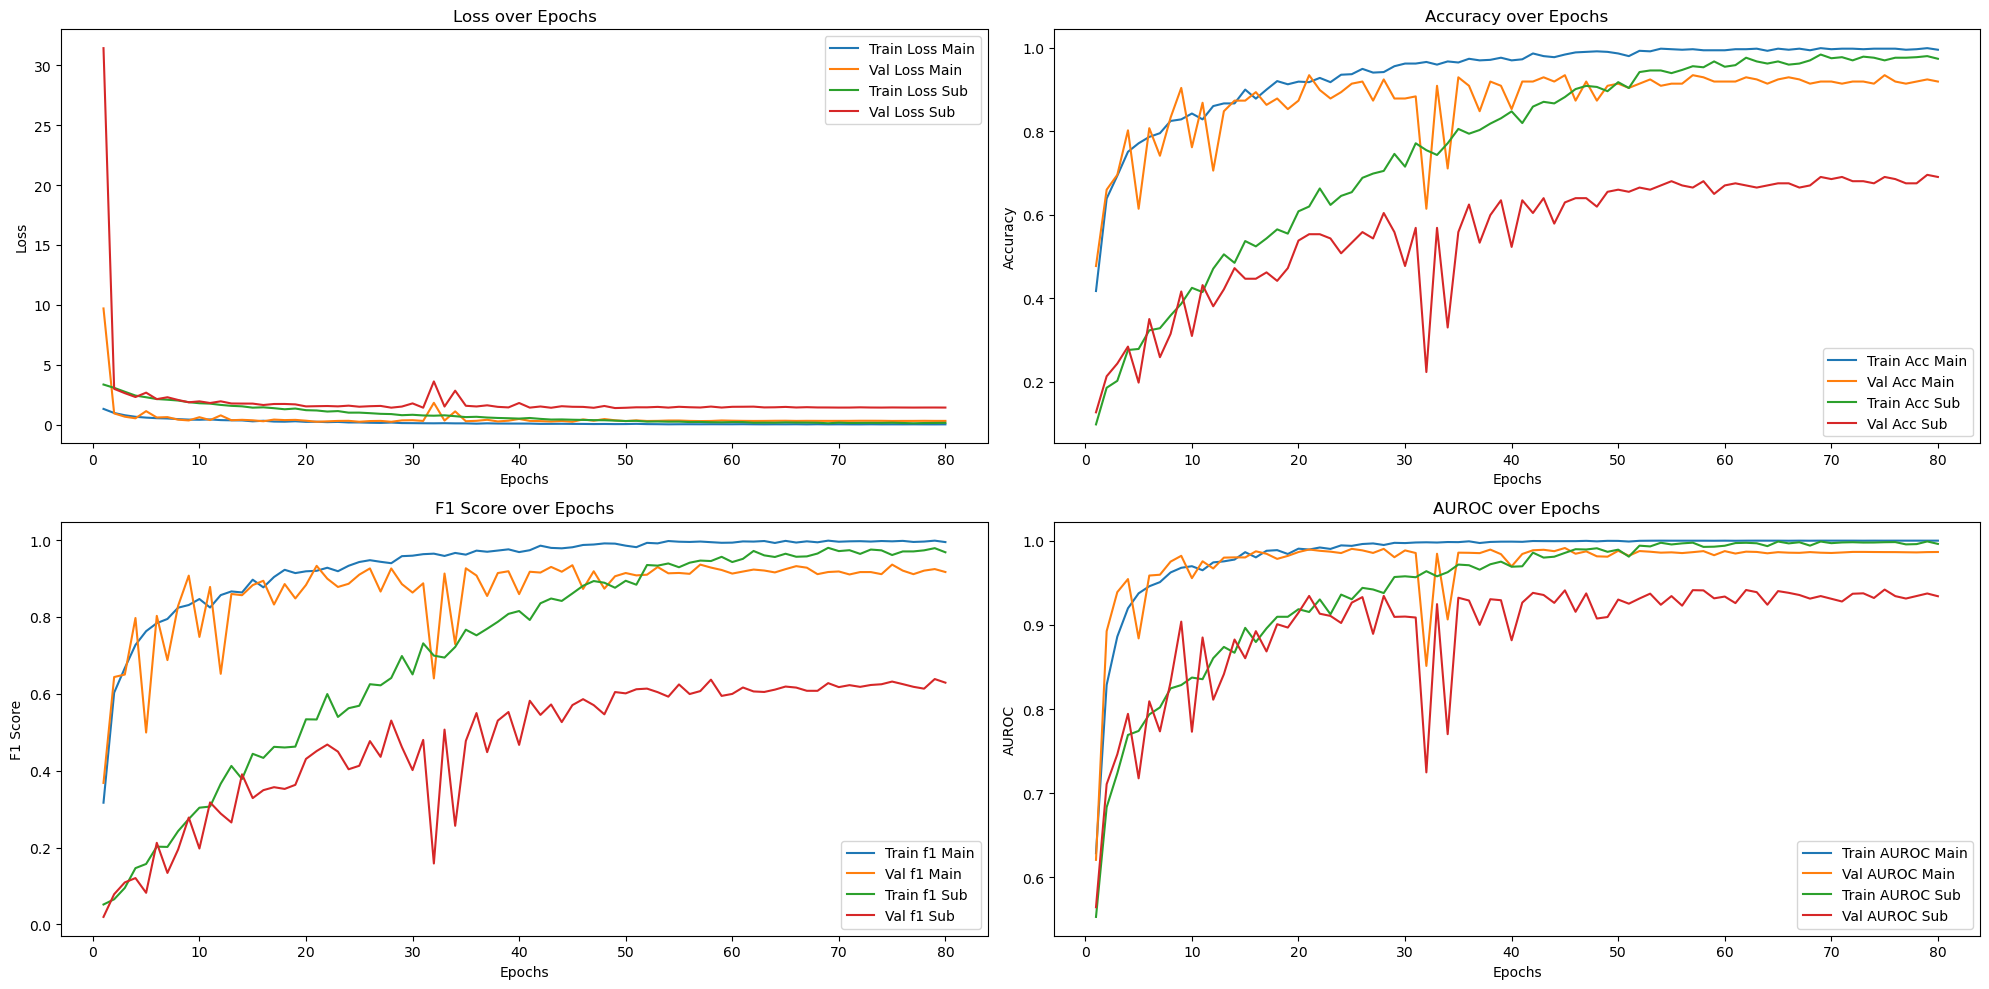

In [22]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss_main']) + 1)

    plt.figure(figsize=(20, 10))

    # plot loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train_loss_main'], label='Train Loss Main')
    plt.plot(epochs, history['val_loss_main'], label='Val Loss Main')
    plt.plot(epochs, history['train_loss_sub'], label='Train Loss Sub')
    plt.plot(epochs, history['val_loss_sub'], label='Val Loss Sub')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # plot accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['train_acc_main'], label='Train Acc Main')
    plt.plot(epochs, history['val_acc_main'], label='Val Acc Main')
    plt.plot(epochs, history['train_acc_sub'], label='Train Acc Sub')
    plt.plot(epochs, history['val_acc_sub'], label='Val Acc Sub')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    # plot f1
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['train_f1_main'], label='Train f1 Main')
    plt.plot(epochs, history['val_f1_main'], label='Val f1 Main')
    plt.plot(epochs, history['train_f1_sub'], label='Train f1 Sub')
    plt.plot(epochs, history['val_f1_sub'], label='Val f1 Sub')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score over Epochs')
    plt.legend()

    # Plot AUROC
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history['train_auroc_main'], label='Train AUROC Main')
    plt.plot(epochs, history['val_auroc_main'], label='Val AUROC Main')
    plt.plot(epochs, history['train_auroc_sub'], label='Train AUROC Sub')
    plt.plot(epochs, history['val_auroc_sub'], label='Val AUROC Sub')
    plt.xlabel('Epochs')
    plt.ylabel('AUROC')
    plt.title('AUROC over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 绘制训练历史
plot_training_history(history)

In [23]:
# save model
model_path = './taskb_resnet34_model.pth'
torch.save(model.state_dict(), model_path)

# 7. Test Model
try to predict a image and draw the confusion matrix

In [24]:
def predict(model, image, sub_class_dict):
    # becasue image is fetch from batch, so drop dimension 
    image = image.to(device).unsqueeze(0)

    model.eval()
    
    with torch.no_grad():
        
        main_logits, sub_logits = model(image)
        
        pred_main = torch.argmax(main_logits, dim=1)
        
        i = pred_main.item()  
        indices = sub_class_dict[i]  
        specified_sub_logit = sub_logits[0][torch.tensor(indices, device=device)]
        max_index = torch.argmax(specified_sub_logit)  
        original_max_index = indices[max_index]  

        pred_sub = original_max_index

    return pred_main.item(), pred_sub



In [25]:
model_path = './taskb_resnet34_model.pth'

num_main_classes = 4
num_sub_classes = 31
model = MultiLevelClassifier(num_main_classes, num_sub_classes, drop_out_rate=0.4)       
model = model.to(device)
model.load_state_dict(torch.load(model_path))       # load trained model
images, mains, subs = next(iter(dataloaders['val']))            
main, sub = predict(model, image=images[0], sub_class_dict=sub_class_dict)

true_main, true_sub = mains[0], subs[0]

true_main, true_sub = task_b_dataset.main_class[true_main], task_b_dataset.sub_class[true_sub]
main, sub =task_b_dataset.main_class[main], task_b_dataset.sub_class[sub]
print(f'Predict main is {main}, true main is {true_main}\nPredict sub is {sub}, true sub is {true_sub}')

Predict main is Accessories, true main is Accessories
Predict sub is Eyewear, true sub is Eyewear


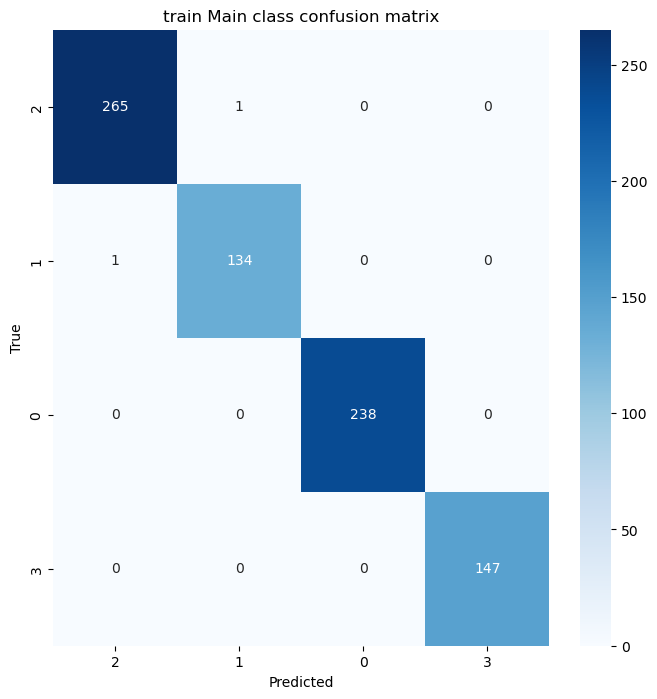

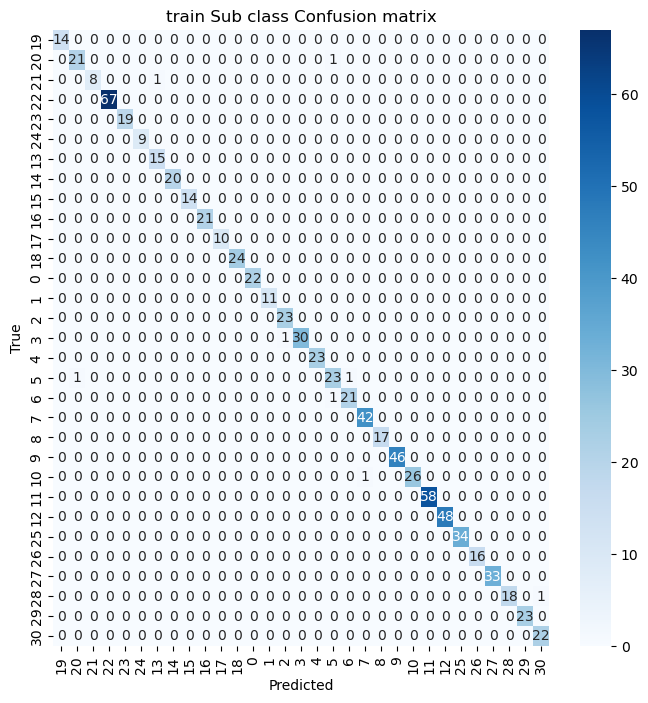

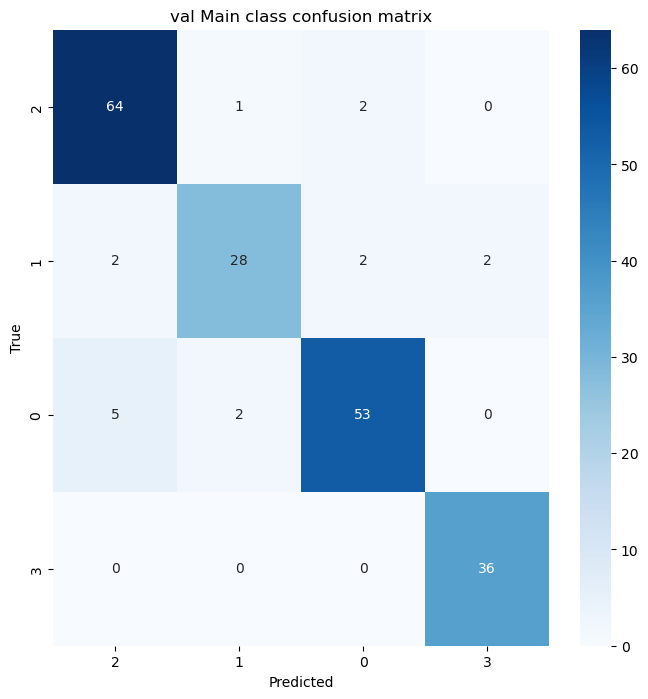

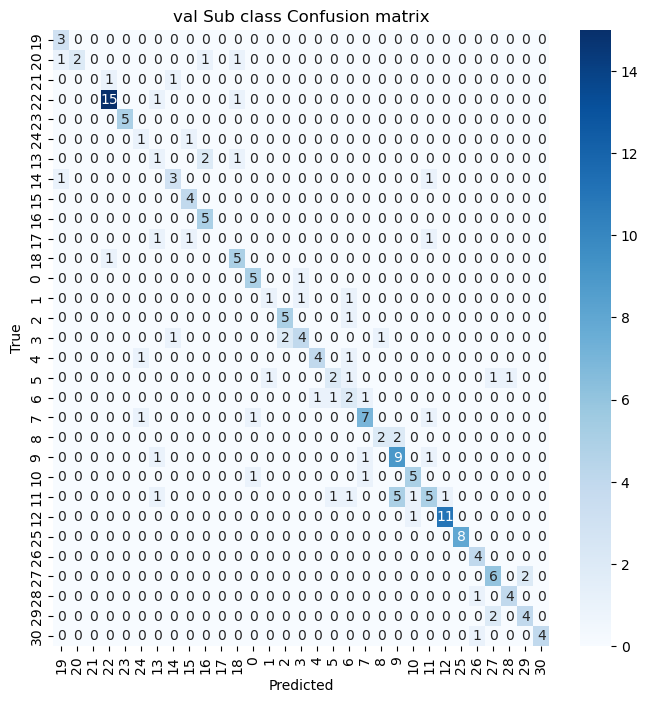

In [26]:
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred, labels, title):
    """ 
    Plot a confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

def generate_confusion_matrices(model, dataloaders, sub_class_dict):
    """   
    Generate confusion matrix by predict result
    """
    

    for phase in ['train', 'val']:
        all_true_main = []
        all_pred_main = []
        all_true_sub = []
        all_pred_sub = []
        for inputs, labels_main, labels_sub in dataloaders[phase]:
            inputs = inputs.to(device)
            labels_main = labels_main.to(device)
            labels_sub = labels_sub.to(device)

            for i in range(inputs.size(0)):
                image = inputs[i]
                true_main = labels_main[i].item()
                true_sub = labels_sub[i].item()

                pred_main, pred_sub = predict(model, image, sub_class_dict)

                all_true_main.append(true_main)
                all_pred_main.append(pred_main)
                all_true_sub.append(true_sub)
                all_pred_sub.append(pred_sub)
        
        # plot main class confusion matrix
        plot_confusion_matrix(all_true_main, all_pred_main, labels=list(sub_class_dict.keys()), title=f'{phase} Main class confusion matrix')

        # plot sub class confusion matrix
        sub_labels = [item for sublist in sub_class_dict.values() for item in sublist]
        plot_confusion_matrix(all_true_sub, all_pred_sub, labels=sub_labels, title=f'{phase} Sub class Confusion matrix')

generate_confusion_matrices(model, dataloaders, sub_class_dict)

# 8. Summary and discussion

This classification result shows the model's performance on main and sub class:

Main category accuracy (91.88%) and F1 score (91.70%) indicate that the model performs very well on main category classification, with high accuracy and a balanced F1 score considering both precision and recall.
Sub-category accuracy (69.04%) and F1 score (62.91%) suggest that the model performs worse on sub-category classification. While there is room for improvement, the overall performance is still acceptable.
AUROC scores for main and sub-categories (98.65% and 93.4%) highlight the model's strong ability to distinguish between positive and negative samples, especially in the main category.
Overall, the model performs excellently in main category classification and has good but improvable performance in sub-category classification.

Compared with vgg16, multi-task learning based on resnet34 has better classification ability and no significant difference in running efficiency. However, the two methods have the same problem, that is, the upper limit is not high, there are signs of overfitting within 100 epochs, and then various data do not significantly improve or even decline, so there is room for improvement in improving generalization ability to prevent overfitting.

